In [1]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
%matplotlib inline



from scipy.spatial import distance
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.utils  import plot_model, model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
DSPATH="../input/olivetti-faces/"
X = np.load(DSPATH+"olivetti_faces.npy")
y = np.load(DSPATH+"olivetti_faces_target.npy")

 
ThiefImage={}
ThiefImage["False"]= image.imread("../input/thief-images/False.jpg")
ThiefImage["True"]=image.imread("../input/thief-images/True.jpg")
 



 

In [3]:
ClASSES=np.unique(y)
# N_CLASSES=len(np.unique(labels))

# **StratifiedSplit Data**

In [4]:
# Split into train/val

StratifiedSplit = StratifiedShuffleSplit( test_size=0.4, random_state=0)
StratifiedSplit.get_n_splits(X, y)
for train_index, test_index in StratifiedSplit.split(X, y):
    X_train, X_test, y_train, y_test= X[train_index], X[test_index], y[train_index], y[test_index]
    
# X_train, X_test, y_train, y_test = train_test_split(    
#     X, y, test_size=.40, random_state=42)
 

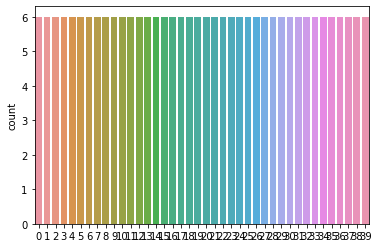

In [5]:
import seaborn as sns
g = sns.countplot(y_train)



# **Calculate Class mean**

In [6]:
# calculate class mean 
class_mean=[]
for i in range(len(X_train)):
    class_mean.append(X_train[y_train==i].mean(axis = 0))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


# **Show Training Data**

In [7]:
#Show Data

def ShowTrainingData(showNclasses=5):
    if showNclasses>=40:
        showNclasses=ClASSES
    rows,cols=2,4
    
    for i in range(showNclasses+1):
        fig,ax =  plt.subplots(rows,cols )
        j=0
        for face in X_train[y_train==i]:
            j+=1
            if j==cols:
                j=5
            ax=plt.subplot(rows,cols,j)
            ax.imshow(face ,'gray' )

        ax = plt.subplot(1,cols,cols)
       
        ax.imshow( class_mean[i], 'gray' )
        plt.xlabel("Class "+str(i)+" mean " )
        fig.tight_layout(pad=1.0)
        plt.show()
    

In [8]:
#Show Data

def ShowTrainingData2(showNclasses):
    if showNclasses>=40:
        showNclasses=ClASSES
    rows,cols=2,4
    
    for i in range(showNclasses+1):
        fig = plt.figure(figsize=(8, 4))
    
        j=0
        for face in X_train[y_train==i]:
            j+=1
            if j==cols:
                j=5
            fig.add_subplot(rows, cols, j)
            plt.imshow(face, cmap = plt.get_cmap('gray'))
 
            plt.axis('off')

        
        fig.add_subplot(1,cols,cols)
        plt.imshow(class_mean[i], cmap = plt.get_cmap('gray'))
        plt.title("class_mean {}".format(i), fontsize=16)
        plt.axis('off')
 #         fig.tight_layout(pad=1.0)


        plt.suptitle("There are 6 image for class {}".format(i), fontsize=15)
        plt.show()

    

In [9]:
def ShowPredictions(predic_Model,ShowNPredictions=5):
    
    if ShowNPredictions>=len(y_predictions):
        ShowNPredictions=len(y_predictions)
    rows,cols=1,3
 
    for index, row in y_predictions.iterrows():
        if (index>ShowNPredictions):
            break
            
        x=int(row["x"])
        actually=int(row["actually"])
        y_predic=int(row[predic_Model+"_predic"])
        IsTrue=str(row[predic_Model+"_True"])

        fig,ax =  plt.subplots(rows,cols )
        j=1
        ax=plt.subplot(rows,cols,j)
        ax.imshow(X_test[x] ,'gray' )
        plt.xlabel("Test Number :"+str(x)  )

        j=2
        ax=plt.subplot(rows,cols,j)
        ax.imshow(class_mean[y_predic] ,'gray' )
        plt.xlabel("Class "+str(y_predic)+" mean " )

        j=3
        ax=plt.subplot(rows,cols,j)
        ax.imshow(ThiefImage[IsTrue] ,'gray' )
        plt.xlabel("Class "+str(actually)+" mean " )



        fig.tight_layout(pad=2.0)
        plt.show()   
   

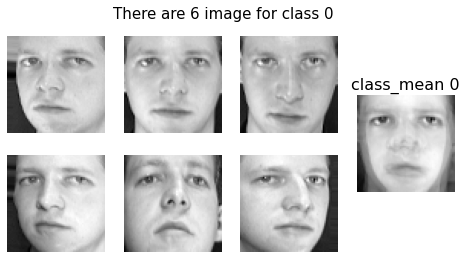

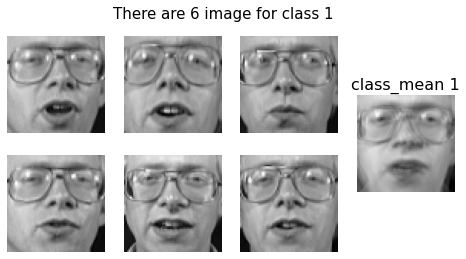

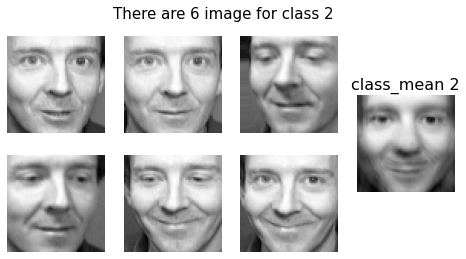

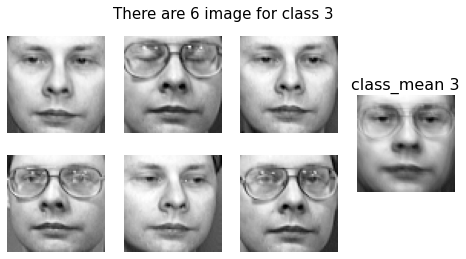

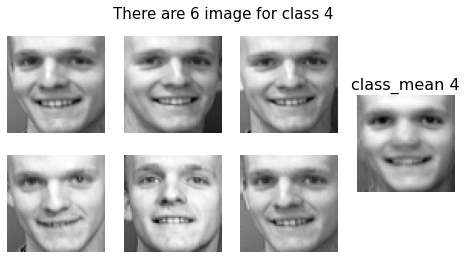

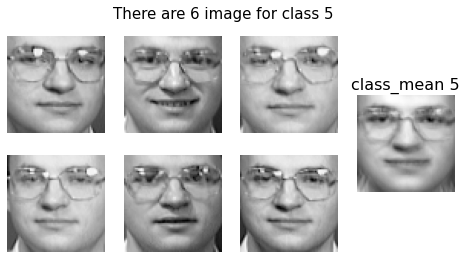

In [10]:
ShowTrainingData2(5)

# **KNN Model**

In [11]:
distanceTable=np.array([(i,y_test[i],c,distance.euclidean(X_test[i].flatten() , class_mean[c].flatten() )) for c in ClASSES  for i in range(len(X_test))])

In [12]:
distanceTable

array([[  0.        ,  21.        ,   0.        ,  16.04539299],
       [  1.        ,   6.        ,   0.        ,  11.14512348],
       [  2.        ,  25.        ,   0.        ,  11.8785553 ],
       ...,
       [157.        ,  34.        ,  39.        ,   9.54059601],
       [158.        ,  19.        ,  39.        ,  12.05138397],
       [159.        ,  23.        ,  39.        ,  11.97078419]])

In [13]:
distanceTable=distanceTable.T
# distanceTable.shape=(4,6400)

In [14]:
 
d = {'x': distanceTable[0], 'actually':distanceTable[1],'KNN_predic':distanceTable[2],'distance':distanceTable[3]}
df= pd.DataFrame(data=d)
df.head()


,x,actually,KNN_predic,distance
0,0.0,21.0,0.0,16.045393
1,1.0,6.0,0.0,11.145123
2,2.0,25.0,0.0,11.878555
3,3.0,11.0,0.0,12.409775
4,4.0,34.0,0.0,9.919844


In [15]:
df[df.x==0]

,x,actually,KNN_predic,distance
0,0.0,21.0,0.0,16.045393
160,0.0,21.0,1.0,12.721321
320,0.0,21.0,2.0,12.928606
480,0.0,21.0,3.0,13.315741
640,0.0,21.0,4.0,13.278010
800,0.0,21.0,5.0,19.731344
960,0.0,21.0,6.0,16.378717
1120,0.0,21.0,7.0,16.181128
1280,0.0,21.0,8.0,13.308956
1440,0.0,21.0,9.0,14.184114


In [16]:
y_predictions=pd.merge(df ,df.groupby(["x","actually"]).distance.min(), how = 'inner',  on=["x","actually","distance"])

In [17]:
y_predictions["KNN_True"]=y_predictions["KNN_predic"]==y_predictions["actually"]

In [18]:
correct_predictions = np.nonzero(y_predictions["KNN_True"].values==1)[0]
incorrect_predictions = np.nonzero(y_predictions["KNN_True"].values==0)[0]
print(len(correct_predictions)," classified correctly")
print(len(incorrect_predictions)," classified incorrectly")

127  classified correctly
33  classified incorrectly


KNN_predic


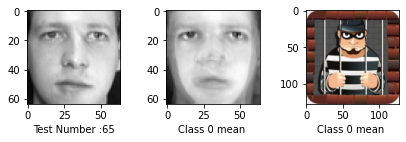

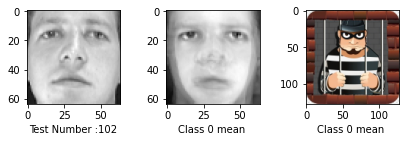

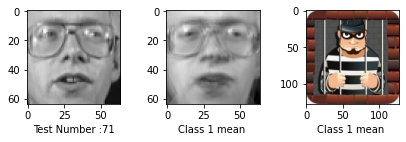

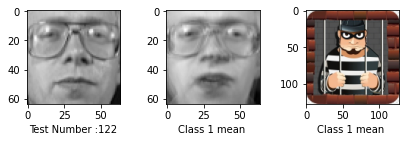

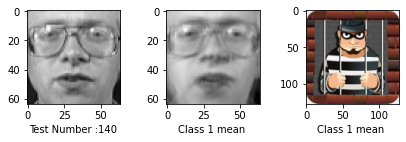

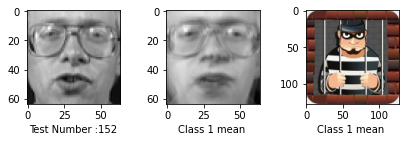

In [19]:
print("KNN_predic")
print("=============")

ShowPredictions("KNN",5)

# **CNN Model**

In [20]:
X_train = X_train.reshape(-1,64,64,1)
X_test = X_test.reshape(-1,64,64,1)
 

print("X_train shape: ",X_train.shape,"y_train shape: ",y_train.shape)
print("x_test shape: ", X_test.shape,"y_test shape: ",y_test.shape)

X_train shape:  (240, 64, 64, 1) y_train shape:  (240,)
x_test shape:  (160, 64, 64, 1) y_test shape:  (160,)


In [21]:
model = Sequential()

model.add(Conv2D(filters = 20, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,1)))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 50, kernel_size = (6,6),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 150, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,1)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(40, activation = "softmax"))



In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)
early_stopping_monitor = EarlyStopping(patience=2)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 20)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 50)        36050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 150)       1

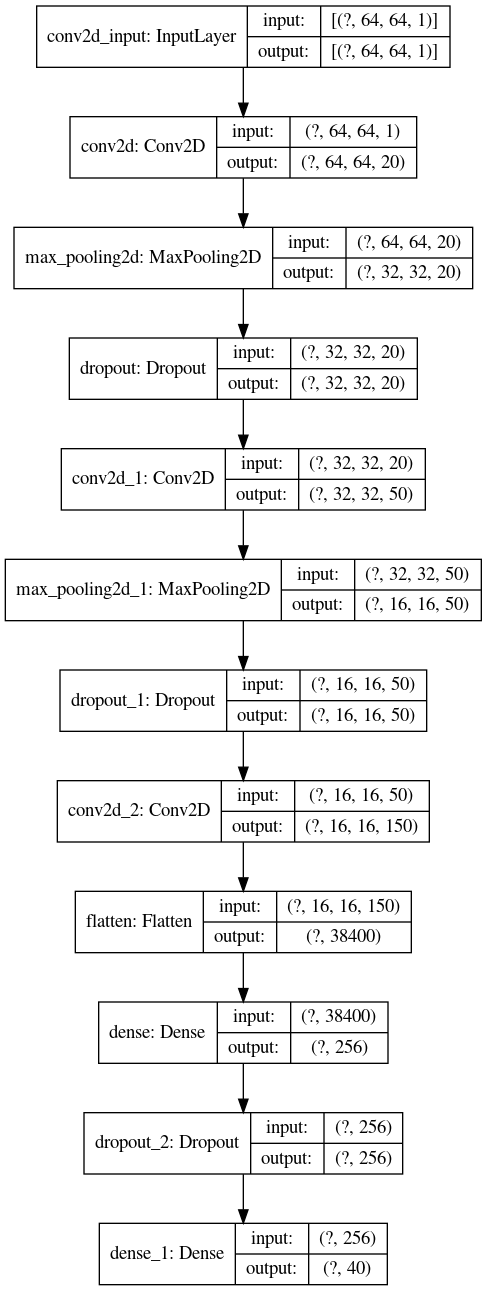

In [24]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])
epoch = 37
batch_size = 20

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

history = model.fit_generator(
                              datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epoch, 
                              validation_data = (X_test,y_test),
                              verbose = 2, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction]
                             )

Epoch 1/37
12/12 - 3s - loss: 5.3874 - sparse_categorical_accuracy: 0.0125 - val_loss: 3.6883 - val_sparse_categorical_accuracy: 0.0250
Epoch 2/37
12/12 - 3s - loss: 3.6964 - sparse_categorical_accuracy: 0.0250 - val_loss: 3.6883 - val_sparse_categorical_accuracy: 0.0250
Epoch 3/37
12/12 - 3s - loss: 3.6896 - sparse_categorical_accuracy: 0.0208 - val_loss: 3.6863 - val_sparse_categorical_accuracy: 0.0250
Epoch 4/37
12/12 - 3s - loss: 3.6915 - sparse_categorical_accuracy: 0.0458 - val_loss: 3.6860 - val_sparse_categorical_accuracy: 0.0437
Epoch 5/37
12/12 - 3s - loss: 3.6909 - sparse_categorical_accuracy: 0.0292 - val_loss: 3.6860 - val_sparse_categorical_accuracy: 0.0250
Epoch 6/37
12/12 - 3s - loss: 3.7014 - sparse_categorical_accuracy: 0.0292 - val_loss: 3.6839 - val_sparse_categorical_accuracy: 0.0250
Epoch 7/37
12/12 - 3s - loss: 3.6820 - sparse_categorical_accuracy: 0.0333 - val_loss: 3.6194 - val_sparse_categorical_accuracy: 0.0437
Epoch 8/37
12/12 - 3s - loss: 3.6468 - sparse_ca

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


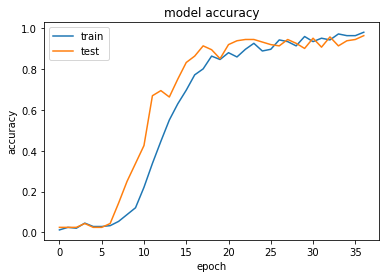

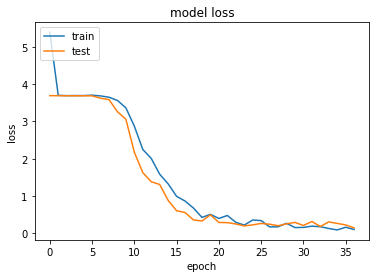

In [26]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
print("CNN_predic")
print("=============")

score = model.evaluate(X_test,y_test,batch_size=32)
print(score)

CNN_predic
5/5 [==============================] - 0s 50ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.9625
[0.14628693461418152, 0.9624999761581421]


In [28]:
CNN_predic=model.predict_classes(X_test)

In [29]:
X_test = X_test.reshape(-1,64,64)

In [30]:
del y_predictions

distanceTable=np.array([(i,y_test[i],CNN_predic[i] )  for i in range(len(X_test))])
distanceTable=distanceTable.T
d = {'x': distanceTable[0], 'actually':distanceTable[1],'CNN_predic':distanceTable[2] }
y_predictions= pd.DataFrame(data=d)
y_predictions.head()
y_predictions["CNN_True"]=y_predictions["CNN_predic"]==y_predictions["actually"]



In [31]:
y_predictions.head(100)

,x,actually,CNN_predic,CNN_True
0,0,21,21,True
1,1,6,6,True
2,2,25,25,True
3,3,11,11,True
4,4,34,34,True
...,...,...,...,...
95,95,24,24,True
96,96,30,30,True
97,97,24,24,True
98,98,8,8,True


In [32]:
correct_predictions = np.nonzero(y_predictions["CNN_True"].values==1)[0]
incorrect_predictions = np.nonzero(y_predictions["CNN_True"].values==0)[0]
print(len(correct_predictions)," classified correctly")
print(len(incorrect_predictions)," classified incorrectly")


154  classified correctly
6  classified incorrectly


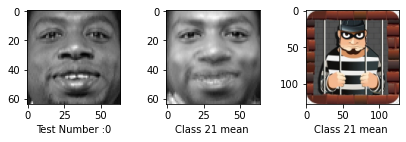

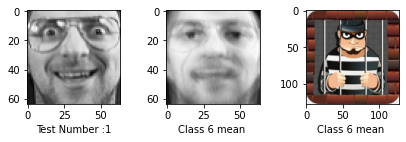

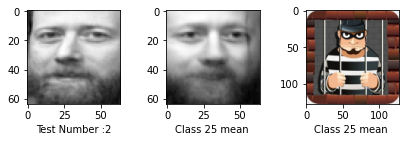

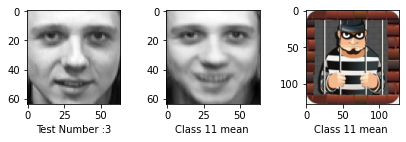

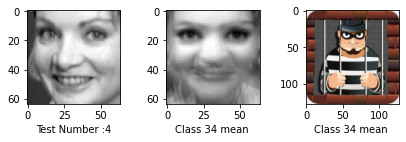

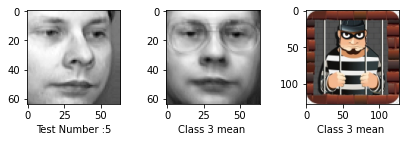

In [33]:


ShowPredictions("CNN")


